<a href="https://colab.research.google.com/github/caxaxa/SigmaGeek_Cellular_Automata/blob/main/Sigma_Geek_Cellular_Atutomata_Q2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Celular Automata Maze

Here you can find the answer for the second fase of the SigmaGeek chalange. 

Availabe at : https://sigmageek.com/challenge/stone-automata-maze-challenge

In [1]:
import numpy as np


In [2]:
#get the second grid from the game
import urllib.request


url = "https://s3.amazonaws.com/appforest_uf/f1678907491882x777874554533324300/input.txt"
response = urllib.request.urlopen(url)
grid0 = np.loadtxt(response, delimiter=" ")



In [3]:
def apply_rule(center, neighbors):
    # Count the number of green neighbors
    green_neighbors = np.count_nonzero(neighbors)
    # Apply the appropriate rule based on the center cell's color and the number of green neighbors
    if center == 0:
        # White cell rule
        if green_neighbors > 1 and green_neighbors < 5:
            return 1  # Turn white cell green
        else:
            return 0  # Keep white cell white
    elif center == 1:
        # Green cell rule
        if green_neighbors > 3 and green_neighbors < 6:
            return 1  # Keep green cell green
        else:
            return 0  # Turn green cell white
    else:
      return center
    

def next_generation(grid):
    # Define function to apply the rules to each cell
    # Get the dimensions of the input grid
    n_rows, n_cols = grid.shape
    # Create a new grid of the same dimensions to store the next generation
    new_grid = np.zeros_like(grid)
    # Loop through each cell in the input grid
    for i in range(n_rows):
        for j in range(n_cols):
            # Get the 8 neighbors of the current cell
            neighbors = np.zeros(9, dtype=np.int8)
            for k in range(3):
                for l in range(3):
                    if k == 1 and l == 1:
                        continue  # Skip the center cell
                    row = i + k - 1
                    col = j + l - 1
                    if row < 0 or row >= n_rows or col < 0 or col >= n_cols:
                        # If a neighbor is out of bounds, treat it as a white cell
                        neighbors[k * 3 + l] = 0
                    else:
                        # Set the neighbor value to 0 if the grid value is greater than 1
                        neighbors[k * 3 + l] = 0 if grid[row, col] > 1 else grid[row,col]
            # Apply the rules to the current cell and store the result in the new grid
            new_grid[i, j] = apply_rule(grid[i, j], neighbors)
    # Return the new grid representing the next generation
    return new_grid



In [4]:
#make a function to generate an array of grids to be the input on the A* algo
def generate_grids(grid0, n): # n is an arbitrary number of grids (big enough to find a solution to the maze)
    grids = [grid0]
    for i in range(n-1):
        new_grid = next_generation(grids[-1])
        grids.append(new_grid)
    return grids
    

In [5]:
grids =  generate_grids(grid0, 300)

In [6]:
from typing import List

# Node class representing a single point in the grid
class Node:
    # Constructor for Node class
    def __init__(self, position, step, g_score=float('inf'), h_score=float('inf'), parent=None):
        self.position = position  # Tuple (x, y) representing the position of the node in the grid
        self.step = step  # Step associated with the grid
        self.g_score = g_score  # Cost from the start node to the current node
        self.h_score = h_score  # Heuristic cost from the current node to the goal node
        self.f_score = g_score + h_score  # Total estimated cost of the path through the current node
        self.parent = parent  # Parent node in the path

    # Equality comparison method
    def __eq__(self, other):
        return self.position == other.position and self.step == other.step

    # Less than comparison method
    def __lt__(self, other):
        return self.f_score < other.f_score or (self.f_score == other.f_score and self.h_score < other.h_score)

    # Hash method for hashing nodes based on their position and step
    def __hash__(self):
        return hash((self.position, self.step))

# Function to reconstruct the path from the goal node to the start node
def reconstruct_path(node):
    path = [(node.position, node.step)]
    while node.parent is not None:
        node = node.parent
        path.append((node.position, node.step))
    return path[::-1]  # Reverse the path so it starts from the start node

# A* search algorithm implementation
def a_star(grids, start, goal):
    open_set = [start]  # Initialize the open set with the start node
    closed_set = set()  # Initialize an empty closed set

    while open_set:  # Continue the search while there are nodes in the open set
        # Find the node with the lowest f_score in the open set
        current = min(open_set, key=lambda node: node.f_score)
        if current.position == goal:  # If the current node is the goal node, return the path
            return reconstruct_path(current)

        open_set.remove(current)  # Remove the current node from the open set
        closed_set.add(current)  # Add the current node to the closed set

        # Loop through the neighbors of the current node
        for dx, dy in ((0, 1), (0, -1), (1, 0), (-1, 0)):
            x, y = current.position[0] + dx, current.position[1] + dy
            if x < 0 or x >= len(grids[0]) or y< 0 or y >= len(grids[0][0]):
                continue  # Skip if the neighbor is out of grid boundaries

            successor_step = (current.step + 1) % len(grids)
            grid = grids[successor_step]
            if grid[x][y] != 0:  # If the grid cell is not traversable, skip this neighbor
                continue

            # Create a successor node with the current node as its parent
            successor = Node(position=(x, y), step=successor_step, parent=current)
            if successor in closed_set:  # Skip if the successor node is already in the closed set
                continue

            tentative_g_score = current.g_score + 1  # Calculate the tentative g_score for the successor node

            if successor in open_set:  # If the successor is already in the open set, update its scores if needed
                if tentative_g_score < successor.g_score:
                    successor                    .g_score = tentative_g_score
                    successor.h_score = abs(x - goal[0]) + abs(y - goal[1])
                    successor.f_score = successor.g_score + successor.h_score
                    successor.parent = current
            else:  # If the successor is not in the open set, calculate its scores and add it to the open set
                successor.g_score = tentative_g_score
                successor.h_score = abs(x - goal[0]) + abs(y - goal[1])
                successor.f_score = successor.g_score + successor.h_score
                open_set.append(successor)

    return 'No Paths to the goal in {} steps.'.format(len(grids))  # If there is no path to the goal with the providen grid



In [7]:
# Define the start and goal nodes
start = Node(position=(0, 0), step=0, g_score=0, h_score=abs(0 - 65) + abs(0 - 85))
goal = (64, 83) # tried (63,84) it was a longer path (272 steps)

# Run the A* algorithm with a maximum of 5 grids and print the result
path = a_star(grids, start, goal)

In [8]:
#get only the coordenates from the pair position, step
path_points = [t[0] for t in path]
print('The solution has {} steps.'.format(len(path_points)))

The solution has 272 steps.


In [9]:
# Make a function to create the solution as required for the chalange
def path_to_solution(path):
    solution = ''
    for i in range(len(path) - 1):
        curr_pos = path[i][0]
        next_pos = path[i+1][0]
        if next_pos[1] > curr_pos[1]:
            solution += ' R'
        elif next_pos[1] < curr_pos[1]:
            solution += ' L'
        elif next_pos[0] > curr_pos[0]:
            solution += ' D'
        else:
            solution += ' U'
    return solution

In [10]:
 sol = path_to_solution(path)

 with open("sol.txt", "w") as file:
    file.write(sol)

 print(sol)

 R R R R R R R R R R R R R R R R R D D D D D D D D L D U R R L R D R D R D D D R D R R D D R R D D L L D R D D R D D R U R R D R U R U L R R U D R U R R R R R R R R D D R R R D D D R L R D L R R R L U U U R R R D D R U R R R R R D D R L D L U R D R U R D U U L R D D R D R U D U R R D R R R R R L L R R R D D R D D R L U D D D D R U R R R D D R D U R R R L L D R D D R D D D L L L L L R U R R D R L R D R D D L R D D D D D L D D R L L R D U R R R D R R L D D L D D R R U U D R R R L U R R D L D R D L D R L D R D D L R U U L L R D D D D U D R


## Vizualization and Testing

1 - Create an animation of the grid change and the point path; and

2- Check if the solution does not overlaps green cells at any point in the path.

Uncomment the code below to plot the path trhough the maze.

In [11]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import matplotlib.colors as mcolors

# def create_animation(grid0, n, update, plot_grid, path):
#     frames = [grid0]

#     for i in range(n-1):
#         new_frame = update(frames[-1])
#         frames.append(new_frame)

#     def update_plot(frame_number, frames, ax):
#         ax.clear()
#         grid = frames[frame_number]
#         artists, update_point = plot_grid(grid, ax)
#         return update_point(path[frame_number])  # Update the point for the current frame and return the artists

#     fig, ax = plt.subplots()
#     ani = animation.FuncAnimation(fig, update_plot, n, fargs=(frames, ax), interval=200, blit=True)

#     return ani

# def plot_grid(grid, ax):
#     # Create a custom colormap
#     cmap = mcolors.ListedColormap(['white', 'green', 'yellow'])
#     bounds = [-0.5, 0.5, 1.5, np.max(grid) + 0.5]
#     norm = mcolors.BoundaryNorm(bounds, cmap.N)

#     # Plot the grid with the custom colormap
#     ax.imshow(grid, cmap=cmap, norm=norm, aspect='auto')

#     # Function to update the point color based on the given point (x, y)
#     def update_point(point):
#         y, x = point
#         if grid[y, x] == 0:
#             point_color = 'black'
#         else:
#             point_color = 'red'
#         point_artist, = ax.plot(x, y, 'o', markersize=10, color=point_color)  # Use the specified color for the point
#         ax.set_title(f'Point: {point}')
#         return [point_artist]

#     return ax, update_point


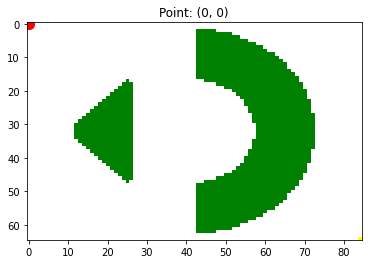

In [12]:
# ani = create_animation(grid0, len(path_points), next_generation, plot_grid, path_points)

In [13]:
# # To vizalise on jupyter notebook
# from IPython.display import HTML


# # Define a function to display the animation in HTML
# def display_animation(anim):
#     plt.close(anim._fig)
#     return HTML(anim.to_jshtml())

# # Display the animation
# display_animation(ani)

In [14]:
# Saving the solution
#ani.save('my_sol.mp4')